In [10]:
import torch 
import torch.nn as nn
from pytorch_metric_learning.losses import NTXentLoss
from torch.utils.data import Dataset, DataLoader
import random

In [11]:
class ContrastiveLearning(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim, projection_dim, dropout_rate=0.25):
        super(ContrastiveLearning, self).__init__()

        self.encoder = nn.Sequential(
                nn.Linear(input_dim, 1028),
                nn.BatchNorm1d(1028),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(1028, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, embedding_dim),
            )

        self.projector = nn.Sequential(
                nn.Linear(embedding_dim, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(256, projection_dim),
            )

        
    def forward(self, x):
        embedding = self.encoder(x)
        projection = self.projector(embedding)
        return projection

In [12]:
criterion = NTXentLoss(temperature=0.10)

In [13]:
import pandas as pd
dataset = pd.read_excel("data/clustered_data.xlsx", index_col=0)
cluster_labels = dataset.cluster_labels
dataset.drop("cluster_labels", axis = 1, inplace = True)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = dataset.shape[1]
embedding_dim = 32
projection_dim = 8

model = ContrastiveLearning(input_dim, embedding_dim, projection_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
class ClusterContrastiveDataset(Dataset):
    def __init__(self, data, cluster_labels):
        self.data = data
        self.cluster_labels = cluster_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = self.cluster_labels.iloc[idx]
        positive_indices = [i for i, same_label in enumerate(self.cluster_labels) if same_label == label and i != idx]
        positive_idx = random.choice(positive_indices)
        positive_item = self.data.iloc[positive_idx]

        item_tensor = torch.tensor(item, dtype=torch.float32)
        positive_item_tensor = torch.tensor(positive_item, dtype=torch.float32)


        return item_tensor, positive_item_tensor

In [16]:
dataset = ClusterContrastiveDataset(data=dataset, cluster_labels=cluster_labels)

dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

In [17]:
def train(num_epochs, log_interval): 

   for epoch in range(num_epochs):
        model.train()  
        total_loss = 0

        for batch_idx, (data_i, data_j) in enumerate(dataloader):

            data_i, data_j = data_i.float().to(device), data_j.float().to(device)

            optimizer.zero_grad()  

            projections_i = model(data_i)
            projections_j = model(data_j)

            # Concatenate the projections: 
            # The positive pairs are adjacent to each other, and all others are considered negatives.
            projections = torch.cat([projections_i, projections_j], dim=0)
            
            batch_size = projections_i.size(0)
            labels = torch.arange(batch_size, dtype=torch.long).to(device)
            labels = torch.cat((labels, labels), dim=0)  # Duplicate labels for both halves of concatenated data

            # Calculate the contrastive loss
            loss = criterion(projections, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')

In [51]:
train(50,1)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_3868/652672158.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  item_tensor = torch.tensor(item, dtype=torch.float32)
/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_3868/652672158.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positive_item_tensor = torch.tensor(positive_item, dtype=torch.float32)


Epoch: 0, Batch: 0, Loss: 4.794651031494141
Epoch: 0, Batch: 1, Loss: 4.783860206604004
Epoch: 0, Batch: 2, Loss: 4.773909091949463
Epoch: 0, Batch: 3, Loss: 4.728622913360596
Epoch: 0, Batch: 4, Loss: 4.737636566162109
Epoch: 0, Batch: 5, Loss: 3.146580934524536
Epoch: 1, Batch: 0, Loss: 4.797337532043457
Epoch: 1, Batch: 1, Loss: 4.731673240661621
Epoch: 1, Batch: 2, Loss: 4.748998641967773
Epoch: 1, Batch: 3, Loss: 4.779931545257568
Epoch: 1, Batch: 4, Loss: 4.764553070068359
Epoch: 1, Batch: 5, Loss: 3.0996713638305664
Epoch: 2, Batch: 0, Loss: 4.81353759765625
Epoch: 2, Batch: 1, Loss: 4.792298793792725
Epoch: 2, Batch: 2, Loss: 4.786014080047607
Epoch: 2, Batch: 3, Loss: 4.748126029968262
Epoch: 2, Batch: 4, Loss: 4.745288848876953
Epoch: 2, Batch: 5, Loss: 3.1414198875427246
Epoch: 3, Batch: 0, Loss: 4.749800682067871
Epoch: 3, Batch: 1, Loss: 4.768197059631348
Epoch: 3, Batch: 2, Loss: 4.783574104309082
Epoch: 3, Batch: 3, Loss: 4.808216571807861
Epoch: 3, Batch: 4, Loss: 4.740

In [52]:
model.eval()

# Convert the Pandas series to a tensor and add an extra batch dimension
single_sample = torch.tensor(dataset.data.iloc[100].values).float().unsqueeze(0)

model.encoder(single_sample)

tensor([[ 1.2817, -0.4411,  3.5200,  2.0944, -2.2836,  0.9526, -0.5476,  1.3603,
          1.1678,  1.6204,  1.5734,  1.2978, -1.7011,  1.3844, -1.2452, -0.5027,
          0.0116,  1.2725, -1.9556,  2.1620, -1.5784,  1.7728,  0.7969,  1.7980,
          3.2006,  0.3538,  4.4041,  1.3347,  0.9212,  0.3717, -0.1729, -1.1462]],
       grad_fn=<AddmmBackward0>)

In [53]:
from finch import FINCH

embeddings = model.encoder(torch.tensor(dataset.data.values).float()).detach()

if embeddings.is_cuda:
    embeddings = embeddings.cpu()

embeddings_np = embeddings.numpy()

c, num_clust, req_c = FINCH(embeddings_np)

Partition 0: 222 clusters
Partition 1: 39 clusters
Partition 2: 11 clusters
Partition 3: 6 clusters


In [56]:
new_clusters =  pd.DataFrame(c)[3].values

In [57]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_score = adjusted_rand_score(cluster_labels.values, new_clusters)
nmi_score = normalized_mutual_info_score( cluster_labels.values, new_clusters)

print("Adjusted Rand Index:", ari_score)
print("Normalized Mutual Information:", nmi_score)

Adjusted Rand Index: 0.9999527374250358
Normalized Mutual Information: 0.99868718002903


After 3 Epochs:

Adjusted Rand Index: 0.39013729831115246

Normalized Mutual Information: 0.4714099218413295

After 30 Epochs:

Adjusted Rand Index: 0.7512984800014495

Normalized Mutual Information: 0.8561144049085224

After 80 Epochs:

Adjusted Rand Index: 0.9999527374250358

Normalized Mutual Information: 0.99868718002903

In [62]:
pd.DataFrame(embeddings, index = cluster_labels.index)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,2.553570,2.437371,-1.715173,-0.000141,2.476230,1.151218,-2.490286,-3.177473,0.405554,-1.709524,...,0.352731,-1.650639,-0.975993,-2.160415,-2.646643,1.282905,0.854841,-0.502758,-2.264122,1.292458
1,-1.105265,0.698783,-0.091378,-1.658293,0.792008,-0.948901,2.012497,1.074972,-2.463925,-0.564503,...,-0.046945,-2.076784,1.160543,0.269150,-2.618131,-0.660769,0.756346,-0.012739,1.089700,-1.050411
2,-1.267552,1.023226,0.326287,-1.152038,0.416813,-1.498401,2.564859,1.635240,-2.554638,-1.017010,...,-0.447528,-2.518605,1.277730,0.107462,-2.502673,-0.337323,0.614517,-1.051530,0.593055,-1.105545
3,-1.726388,0.303991,0.016377,-1.814209,-0.411364,-1.243684,2.470309,1.571812,-2.152457,-0.697680,...,-1.073795,-2.024717,1.403470,0.663657,-2.417771,-0.736225,0.079382,-0.103269,1.207968,-1.296221
5,1.550744,1.008602,-2.223149,-0.724061,1.898412,0.788973,-3.117771,-3.265782,1.387697,-1.066890,...,0.433379,-0.342305,-2.451217,-1.748123,-0.976544,-0.047156,0.298318,0.008882,-1.863904,2.006966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,-0.068362,0.975220,0.367304,0.091341,0.957033,0.079977,2.459165,0.670324,-2.758854,-0.315248,...,-0.555773,-3.226155,1.753659,-0.256541,-3.839523,-0.400211,0.216505,-1.128100,0.281990,-1.374512
1925,1.795240,1.909542,-3.363242,-0.674419,2.256959,-0.189523,-2.780438,-3.204798,1.139046,-1.864694,...,0.684957,-0.943806,-2.798532,-0.993318,-1.218063,-0.579431,1.244465,0.459259,-1.989156,1.347888
1929,2.707435,-0.539687,3.879393,2.220239,-1.526163,2.249579,-1.277422,0.984060,1.767248,2.213034,...,1.543711,1.547243,2.574876,-0.314900,4.183454,1.815845,0.505431,0.239706,-0.875441,-0.060610
1930,-1.815422,-0.283469,-0.974772,-1.319811,-0.851714,-0.306743,0.031885,0.812339,0.071571,-1.294136,...,0.343353,1.019421,-0.105226,0.578383,1.983958,0.690844,-0.270451,1.486466,0.620055,-0.262823


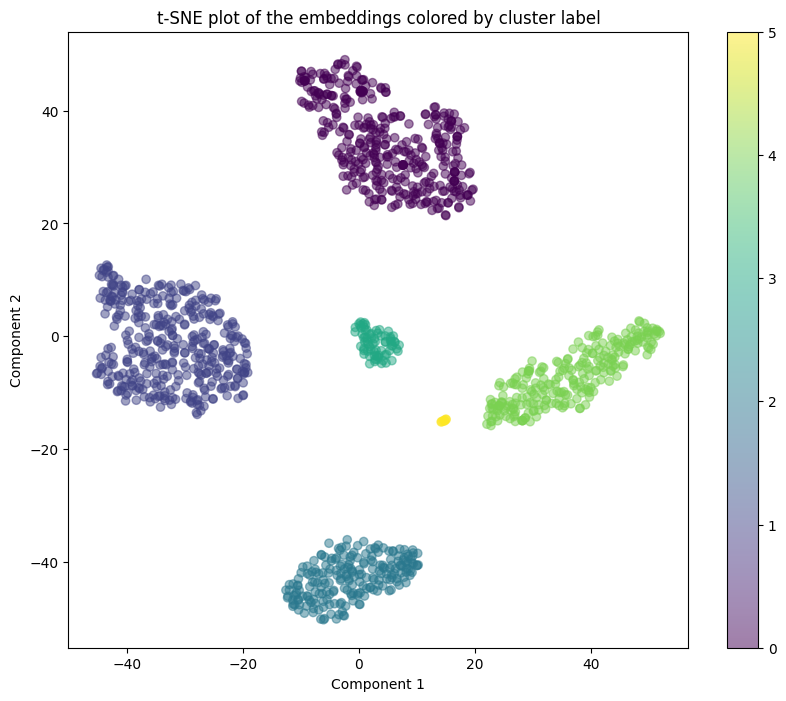

In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embeddings' is a numpy array of your data embeddings
# And 'cluster_labels' is an array of cluster labels corresponding to each point in 'embeddings'
embeddings_2d = TSNE(n_components=2, random_state=0).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=new_clusters, cmap='viridis', alpha=0.5)
plt.colorbar()  # To show the color scale
plt.title('t-SNE plot of the embeddings colored by cluster label')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

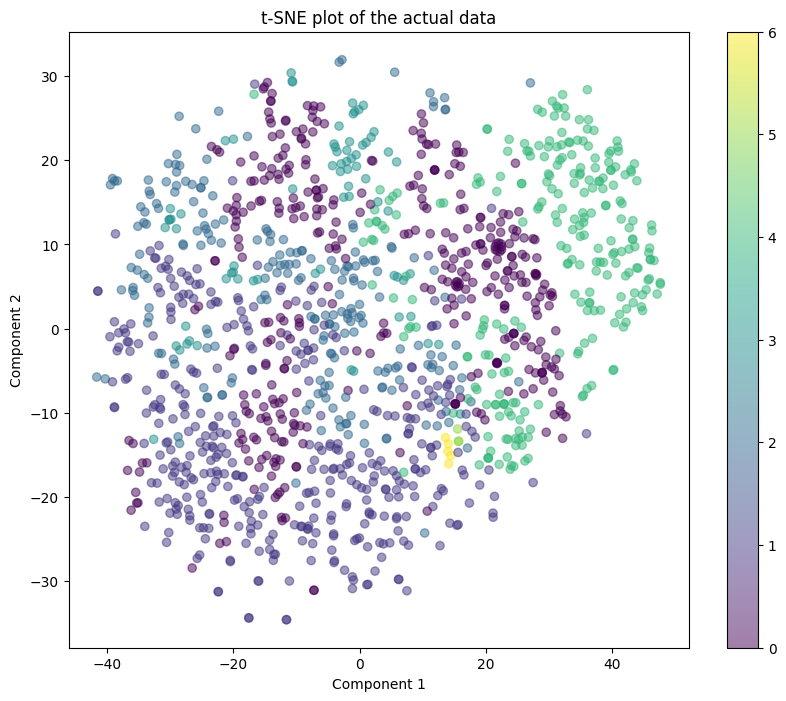

In [74]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = pd.read_excel("data/clustered_data.xlsx", index_col=0)
data.drop("cluster_labels", axis=1, inplace=True)
embeddings_2d = TSNE(n_components=2, random_state=0).fit_transform(data)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.colorbar()  # To show the color scale
plt.title('t-SNE plot of the actual data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()